# 0_Impact_of_Censoring_and_Truncating_on_the_Estimator

This notebook demostrates the impact of the censoring and truncation on the Linear Bayesian Regression.


In [1]:
!pip install -q pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 6.2 MB/s eta 0:00:00


In [188]:
import os
from functools import partial

import torch
import torch.nn as nn
import torch.distributions.constraints as constraints

import numpy as np

import pyro
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)

## Sampling From Normal Distribution

* likelihood estimation of the parameters of censored and truncated distribution to demonstrate the impact of the transformations on the underlying normal distribution

In [328]:
def optimise_likelihood(x, num_iterations=1000):
    pyro.clear_param_store()
    loc_ = torch.tensor([0.], requires_grad=True)
    scale_ = torch.tensor([1.], requires_grad=True)
    optimizer = torch.optim.Adam([loc_, scale_], lr=0.05)

    pbar = tqdm(range(num_iterations), position=0, leave=True)

    losses = []
    for epoch in pbar:
        optimizer.zero_grad()
        pX = dist.torch.Normal( loc_, scale_)
        loss = -pX.log_prob(x).mean()     # "forward" compute the loss (neg avg log-likelihood)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()                   # "backward" compute the gradient (& unfortunately clear stuff)
        losses.append(loss.item())
    res = {
        'loc': loc_.item(),
        'scale' : scale_.item()
        }
    return res

In [491]:
N = 500
true_sigma = 5.0
true_loc = 13.


# generate the data
X = dist.Uniform(torch.tensor([-5.]), torch.tensor([35.0]))
Y = dist.Normal(torch.Tensor([true_loc]), torch.Tensor([true_sigma]))

x = X.sample(sample_shape=(N,))
y = Y.sample(sample_shape=(N,))

# censor the data
lower_bound = 3.
upper_bound = 16.

y_censored = torch.clamp(y, min=lower_bound, max=upper_bound)
mask = (y < lower_bound)  | (y > upper_bound)
y_censored_indices = torch.nonzero(mask, as_tuple=True)[0]
y_truncated_indices = torch.nonzero(~mask, as_tuple=True)[0]

x_truncated = x[y_truncated_indices]
y_truncated = y[y_truncated_indices]

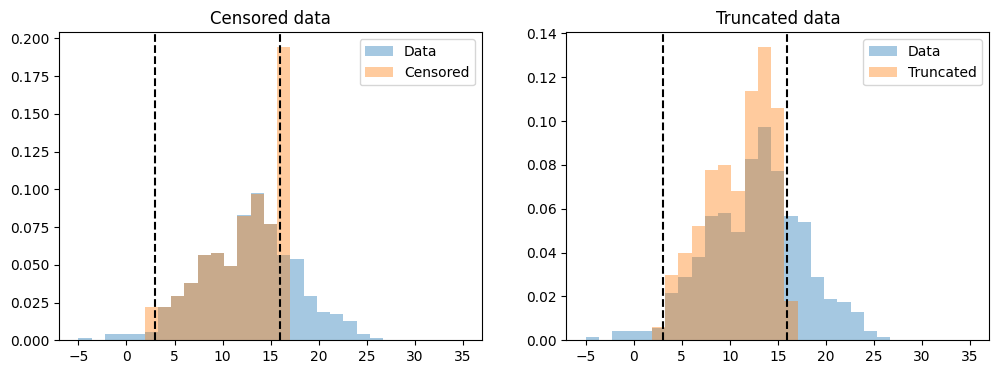

In [504]:
# Visualize uncensored, censored and truncated data
_, ax = plt.subplots(1,2, figsize=(12, 4))
edges = np.linspace(-5, 35, 30)
for ax_ in ax:
  ax_.hist(y.numpy(), bins=edges, density=True, histtype="stepfilled", alpha=0.4, label="Data")
  [ax_.axvline(x=x, c="k", ls="--") for x in [lower_bound, upper_bound]]

ax[0].hist(y_censored.numpy(), bins=edges, density=True, histtype="stepfilled", alpha=0.4, label="Censored")
ax[0].legend()
_ = ax[0].set(title="Censored data")

ax[1].hist(y_truncated.numpy(), bins=edges, density=True, histtype="stepfilled", alpha=0.4, label="Truncated")
ax[1].legend()
_ = ax[1].set(title="Truncated data")

In [498]:
# parameters for non-censored data are: loc = 13., scale =5.
print(" all data")
print(optimise_likelihood(y, 10000))
print('sample mean: {: .5f}, sample std: {: .5f}'.format(y.mean().item(), y.std().item()))

 all data


  0%|          | 0/10000 [00:00<?, ?it/s]

{'loc': 12.657666346701298, 'scale': 5.1386838392769505}
sample mean:  12.65767, sample std:  5.14383


In [501]:
# parameters for non-censored data are: loc = 13., scale =5.
print("censored")
print(optimise_likelihood(y_censored, 10000))
print('sample mean: {: .5f}, sample std: {: .5f}'.format(y_censored.mean().item(), y_censored.std().item()))

censored


  0%|          | 0/10000 [00:00<?, ?it/s]

{'loc': 12.005194732839353, 'scale': 3.8819625095408057}
sample mean:  12.00519, sample std:  3.88585


In [503]:
# parameters for non-censored data are: loc = 13., scale =5.
print("truncated")
print(optimise_likelihood(y_truncated, 10000))
print('sample mean: {: .5f}, sample std: {: .5f}'.format(y_truncated.mean().item(), y_truncated.std().item()))

truncated


  0%|          | 0/10000 [00:00<?, ?it/s]

{'loc': 10.927265472230514, 'scale': 3.3792040666840895}
sample mean:  10.92727, sample std:  3.38387


## Regression Model
* generate data for the regression model

In [334]:
N = 500
slope = 1.
true_sigma = 2.0
intercept = 1.


# generate the data
X = dist.Uniform(torch.tensor([-10.]), torch.tensor([10.0]))
eps = dist.Normal(torch.Tensor([0]), torch.Tensor([true_sigma]))

x = X.sample(sample_shape=(N,))
noise = eps.sample(sample_shape=(N,))
y = intercept + slope * x + noise

# censor the data
lower_bound = -4.
upper_bound = 4.

y_censored = torch.clamp(y, min=lower_bound, max=upper_bound)
mask = (y < lower_bound)  | (y > upper_bound)
y_censored_indices = torch.nonzero(mask, as_tuple=True)[0]
y_truncated_indices = torch.nonzero(~mask, as_tuple=True)[0]

x_truncated = x[y_truncated_indices]
y_truncated = y[y_truncated_indices]

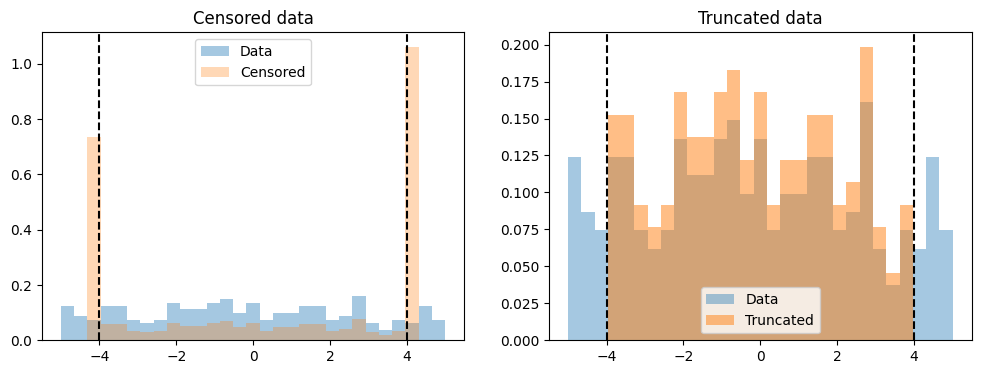

In [436]:
# Visualize uncensored, censored and truncated data
_, ax = plt.subplots(1,2, figsize=(12, 4))
edges = np.linspace(-5, 5, 30)
for ax_ in ax:
  ax_.hist(y.numpy(), bins=edges, density=True, histtype="stepfilled", alpha=0.4, label="Data")
  [ax_.axvline(x=x, c="k", ls="--") for x in [lower_bound, upper_bound]]

ax[0].hist(y_censored.numpy(), bins=edges, density=True, histtype="stepfilled", alpha=0.3, label="Censored")
ax[0].legend()
_ = ax[0].set(title="Censored data")

ax[1].hist(y_truncated.numpy(), bins=edges, density=True, histtype="stepfilled", alpha=0.5, label="Truncated")
ax[1].legend()
_ = ax[1].set(title="Truncated data")


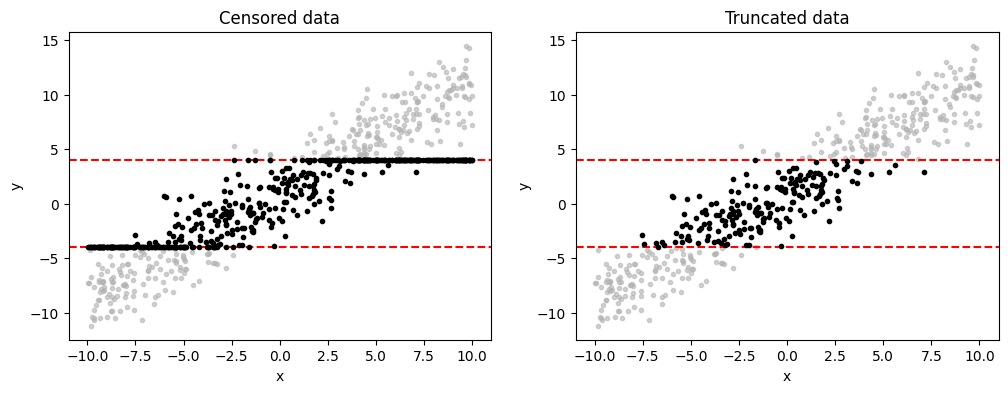

In [336]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for ax_ in ax:
  ax_.plot(x, y, ".", alpha=0.6, c=[0.7, 0.7, 0.7])
  ax_.axhline(lower_bound, c='red', ls="--")
  ax_.axhline(upper_bound, c='red', ls="--")
  ax_.set(xlabel="x", ylabel="y")

ax[0].plot(x.squeeze().numpy(), y_censored.numpy(), ".", c='black')
_ = ax[0].set(title="Censored data")
ax[1].plot(x_truncated.numpy(), y_truncated.numpy(), ".", c='black')
_ = ax[1].set(title="Truncated data")

### Linear Regression

In [337]:
class LinearRegressionModel(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = torch.nn.Linear(in_features, out_features)  # Single input feature, single output

    def forward(self, x):
        return self.linear(x)

def optimise_lin_reg(model, x, y, num_iterations=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    oss_fn = torch.nn.MSELoss(reduction='sum')

    pbar = tqdm(range(num_iterations), position=0, leave=True)

    losses = []
    for epoch in pbar:
        optimizer.zero_grad()
        y_pred = model(x) #forward pass
        loss = loss_fn(y_pred, y)
        loss.backward()
        # take a gradient step
        optimizer.step()
        losses.append(loss.item())
    res = {
        'model': model,
        'losses' : losses
        }
    for name, param in model.named_parameters():
      print(name, param.data.numpy())
    return res

def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


In [370]:
# original parameters are: slope = 1., intercept = 1., sigma = 2.
pyro.clear_param_store()

model1 = LinearRegressionModel(1, 1)
model1_res = optimise_lin_reg(model1, x, y, 5000)
y_pred = model1(x).detach().cpu().numpy()

  0%|          | 0/5000 [00:00<?, ?it/s]

linear.weight [[1.0051764]]
linear.bias [1.10702771]


In [371]:
# original parameters are: slope = 1., intercept = 1., sigma = 2.
pyro.clear_param_store()

model2 = LinearRegressionModel(1, 1)
model2_res = optimise_lin_reg(model2, x, y_censored, 5000)
y_censored_pred = model2(x).detach().cpu().numpy()

  0%|          | 0/5000 [00:00<?, ?it/s]

linear.weight [[0.53353152]]
linear.bias [0.41369395]


In [372]:
# original parameters are: slope = 1., intercept = 1., sigma = 2.
pyro.clear_param_store()

model3 = LinearRegressionModel(1, 1)
model3_res = optimise_lin_reg(model3, x_truncated, y_truncated, 5000)
y_truncated_pred = model3(x).detach().cpu().numpy()

  0%|          | 0/5000 [00:00<?, ?it/s]

linear.weight [[0.55930052]]
linear.bias [0.49965644]


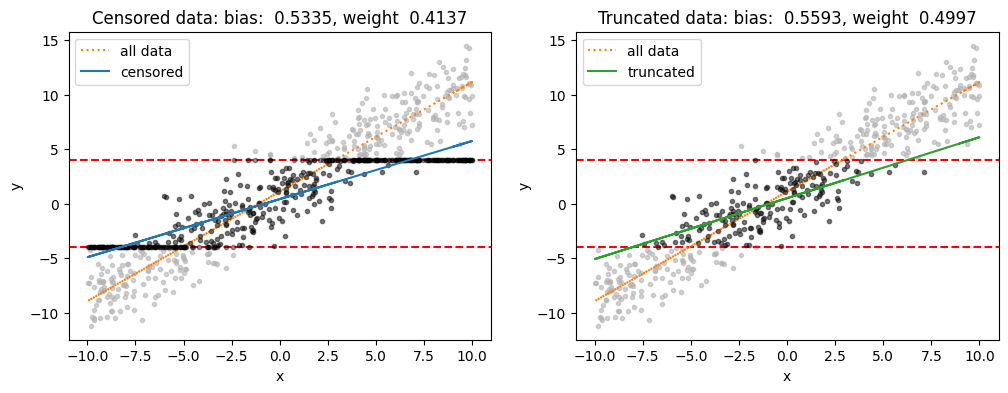

In [374]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for ax_ in ax:
  ax_.plot(x, y, ".", alpha=0.6, c=[0.7, 0.7, 0.7])
  ax_.axhline(lower_bound, c='red', ls="--")
  ax_.axhline(upper_bound, c='red', ls="--")
  ax_.set(xlabel="x", ylabel="y")

ax[0].plot(x, y_pred, color=sns.color_palette()[1], ls=":", label='all data')
ax[1].plot(x, y_pred, color=sns.color_palette()[1], ls=":", label='all data')
ax[0].plot(x.squeeze().numpy(), y_censored.numpy(), ".", c='black', alpha=0.4)
_ = ax[0].set(title="Censored data: bias: {: .4f}, weight {: .4f}".format(model2_res['model'].linear.weight.item(), model2_res['model'].linear.bias.item()))
ax[0].plot(x, y_censored_pred, color=sns.color_palette()[0], label='censored')
ax[1].plot(x_truncated.numpy(), y_truncated.numpy(), ".", c='black', alpha=0.4)
ax[1].plot(x, y_truncated_pred, color=sns.color_palette()[2], label='truncated')
_ = ax[1].set(title="Truncated data: bias: {: .4f}, weight {: .4f}".format(model3_res['model'].linear.weight.item(), model3_res['model'].linear.bias.item()))

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

### Bayessian Regression

In [393]:
from pyro.nn import PyroSample


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 1.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.HalfNormal(1.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean


def optimise_bayes_lin_reg(model, guide, x, y, num_iterations=1000):
    pyro.clear_param_store()
    optimizer = pyro.optim.Adam({'lr': 0.05})
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    svi = SVI(model, guide, optimizer, loss=loss_fn)

    pbar = tqdm(range(num_iterations), position=0, leave=True)

    losses = []
    for epoch in pbar:
        loss = svi.step(x, y)
        losses.append(loss)

    res = {
        'model': model,
        'guide': guide,
        'losses': losses
        }
    return res


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

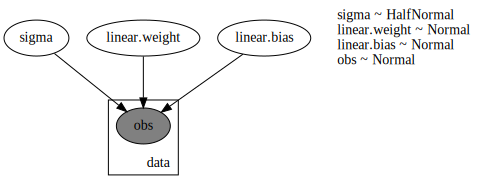

In [384]:
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO

pyro.clear_param_store()

x_train = torch.Tensor(x.numpy())
y_train = torch.Tensor(y.squeeze().numpy())
model3 = BayesianRegression(1, 1)
guide3 = AutoDiagonalNormal(model3) # posterior approximation

pyro.render_model(model3, model_args=(x, y), render_distributions=True, render_params=True)

In [385]:
model3_res = optimise_bayes_lin_reg(model3, guide3, x_train, y_train, num_iterations=5000)
print(model3.linear.weight, model3.linear.bias)

  0%|          | 0/5000 [00:00<?, ?it/s]

tensor([[0.3088]]) tensor([0.3473])


In [352]:
pyro.clear_param_store()

x_train = torch.Tensor(x.numpy())
y_train = torch.Tensor(y_censored.squeeze().numpy())
model4 = BayesianRegression(1, 1)
guide4 = AutoDiagonalNormal(model4) # posterior approximation

model4_res = optimise_bayes_lin_reg(model4, guide4, x_train, y_train, num_iterations=5000)
print(model4.linear.weight, model4.linear.bias)


  0%|          | 0/5000 [00:00<?, ?it/s]

tensor([[-0.1838]]) tensor([-0.9649])


In [353]:
pyro.clear_param_store()

x_train = torch.Tensor(x_truncated.numpy())
y_train = torch.Tensor(y_truncated.squeeze().numpy())
model5 = BayesianRegression(1, 1)
guide5 = AutoDiagonalNormal(model5) # posterior approximation

model5_res = optimise_bayes_lin_reg(model5, guide5, x_train, y_train, num_iterations=5000)
print(model5.linear.weight, model5.linear.bias)

  0%|          | 0/5000 [00:00<?, ?it/s]

tensor([[-1.1794]]) tensor([-0.0603])


In [441]:
pyro.clear_param_store()

predictive_y = Predictive(model3, guide=guide3, num_samples=500)
x_test = torch.linspace(-15, 15, 3000)

samples_model3 = predictive_y(torch.Tensor(x_test.reshape(3000, 1)))

pred_summary_model3 = summary(samples_model3)
y_predicted = pred_summary_model3["obs"]
weights_predicted = pred_summary_model3["linear.weight"]

y_pred = y_predicted['mean']
y_perc_5 = y_predicted["5%"]
y_perc_95 = y_predicted["95%"]

In [423]:
pyro.clear_param_store()

predictive_y_censored = Predictive(model4, guide=guide4, num_samples=500)
x_test = torch.linspace(-15, 15, 3000)

samples_model4 = predictive_y_censored(torch.Tensor(x_test.reshape(3000, 1)))

pred_summary_model4 = summary(samples_model4)
y_censored_predicted = pred_summary_model4["obs"]
weights_censored_predicted = pred_summary_model4["linear.weight"]

y_censored_pred = y_censored_predicted['mean']
y_censored_perc_5 = y_censored_predicted["5%"]
y_censored_perc_95 = y_censored_predicted["95%"]

In [427]:
pyro.clear_param_store()

predictive_y_truncated = Predictive(model5, guide=guide5, num_samples=500)
x_test = torch.linspace(-15, 15, 3000)

samples_model5 = predictive_y_censored(torch.Tensor(x_test.reshape(3000, 1)))

pred_summary_model5 = summary(samples_model5)
y_truncated_predicted = pred_summary_model5["obs"]
weights_truncated_predicted = pred_summary_model5["linear.weight"]

y_truncated_pred = y_truncated_predicted['mean']
y_truncated_perc_5 = y_truncated_predicted["5%"]
y_truncated_perc_95 = y_truncated_predicted["95%"]

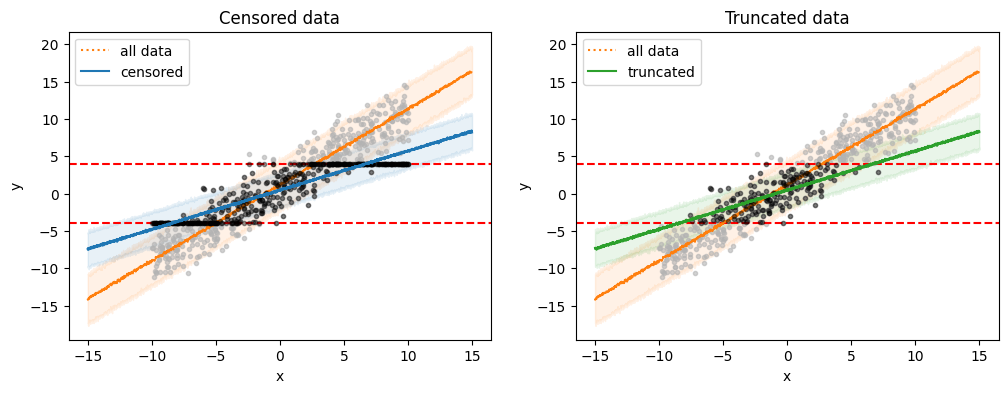

In [434]:

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for ax_ in ax:
  ax_.plot(x, y, ".", alpha=0.6, c=[0.7, 0.7, 0.7])
  ax_.axhline(lower_bound, c='red', ls="--")
  ax_.axhline(upper_bound, c='red', ls="--")
  ax_.set(xlabel="x", ylabel="y")

ax[0].plot(x_test, y_pred, color=sns.color_palette()[1], ls=":", label='all data')
ax[0].fill_between(x_test, y_perc_5, y_perc_95, alpha=0.1, color=sns.color_palette()[1])

_ = ax[0].set(title="Censored data")
ax[0].plot(x.squeeze().numpy(), y_censored.numpy(), ".", c='black', alpha=0.4)
ax[0].plot(x_test, y_censored_pred, color=sns.color_palette()[0], label='censored')
ax[0].fill_between(x_test, y_censored_perc_5, y_censored_perc_95, alpha=0.1, color=sns.color_palette()[0])

ax[1].plot(x_test, y_pred, color=sns.color_palette()[1], ls=":", label='all data')
ax[1].fill_between(x_test, y_perc_5, y_perc_95, alpha=0.1, color=sns.color_palette()[1])

_ = ax[1].set(title="Truncated data")
ax[1].plot(x_truncated.numpy(), y_truncated.numpy(), ".", c='black', alpha=0.4)
ax[1].plot(x_test, y_truncated_pred, color=sns.color_palette()[2], label='truncated')
ax[1].fill_between(x_test, y_truncated_perc_5, y_truncated_perc_95, alpha=0.1, color=sns.color_palette()[2])


ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

#### Posteriors Investigation

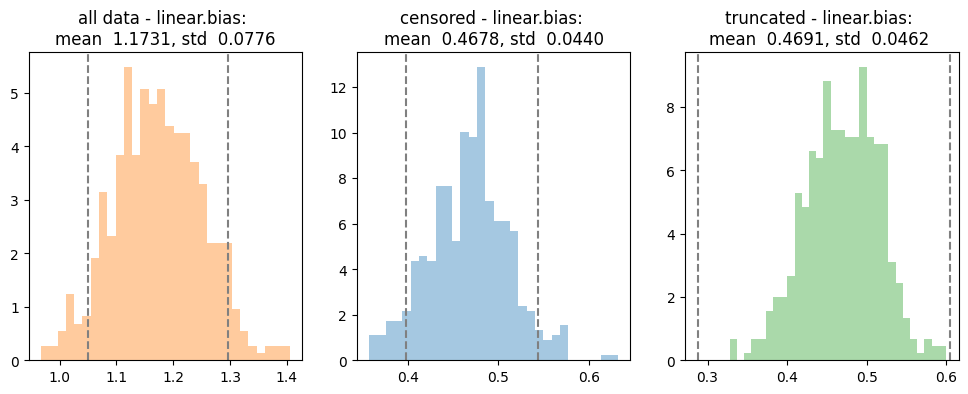

In [489]:
# Visualize uncensored, censored and truncated data
param_ = 'linear.bias'
_, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].hist(samples_model3[param_].squeeze(), density=True, bins=30, alpha=0.4, color=sns.color_palette()[1], label="all data")
[ax[0].axvline(x=x, c="grey", ls="--") for x in guide3.quantiles([0.05, 0.95])[param_].squeeze()]
_ = ax[0].set(title="all data - {}: \nmean {: .4f}, std {: .4f}".format(param_,
    samples_model3[param_].squeeze().mean(), samples_model3[param_].squeeze().std()))

ax[1].hist(samples_model4[param_].squeeze(), density=True, bins=30, alpha=0.4, color=sns.color_palette()[0],  label="censored")
[ax[1].axvline(x=x, c="grey", ls="--") for x in guide4.quantiles([0.05, 0.95])[param_].squeeze()]
_ = ax[1].set(title="censored - {}: \nmean {: .4f}, std {: .4f}".format(param_,
    samples_model4[param_].squeeze().mean(), samples_model4[param_].squeeze().std()))

ax[2].hist(samples_model5[param_].squeeze(), density=True, bins=30, alpha=0.4, color=sns.color_palette()[2], label="truncated")
[ax[2].axvline(x=x, c="grey", ls="--") for x in guide5.quantiles([0.05, 0.95])[param_].squeeze()]
_ = ax[2].set(title="truncated - {}: \nmean {: .4f}, std {: .4f} ".format(param_,
   samples_model5[param_].squeeze().mean(), samples_model5[param_].squeeze().std()))

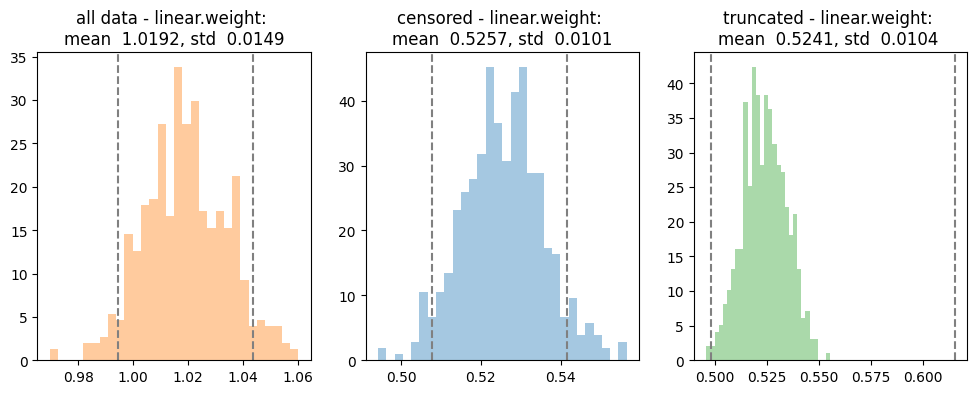

In [488]:
# Visualize uncensored, censored and truncated data
param_ = 'linear.weight'
_, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].hist(samples_model3[param_].squeeze(), density=True, bins=30, alpha=0.4, color=sns.color_palette()[1], label="all data")
[ax[0].axvline(x=x, c="grey", ls="--") for x in guide3.quantiles([0.05, 0.95])[param_].squeeze()]
_ = ax[0].set(title="all data - {}: \nmean {: .4f}, std {: .4f}".format(param_,
    samples_model3[param_].squeeze().mean(), samples_model3[param_].squeeze().std()))

ax[1].hist(samples_model4[param_].squeeze(), density=True, bins=30, alpha=0.4, color=sns.color_palette()[0],  label="censored")
[ax[1].axvline(x=x, c="grey", ls="--") for x in guide4.quantiles([0.05, 0.95])[param_].squeeze()]
_ = ax[1].set(title="censored - {}: \nmean {: .4f}, std {: .4f}".format(param_,
    samples_model4[param_].squeeze().mean(), samples_model4[param_].squeeze().std()))

ax[2].hist(samples_model5[param_].squeeze(), density=True, bins=30, alpha=0.4, color=sns.color_palette()[2], label="truncated")
[ax[2].axvline(x=x, c="grey", ls="--") for x in guide5.quantiles([0.05, 0.95])[param_].squeeze()]
_ = ax[2].set(title="truncated - {}: \nmean {: .4f}, std {: .4f} ".format(param_,
   samples_model5[param_].squeeze().mean(), samples_model5[param_].squeeze().std()))

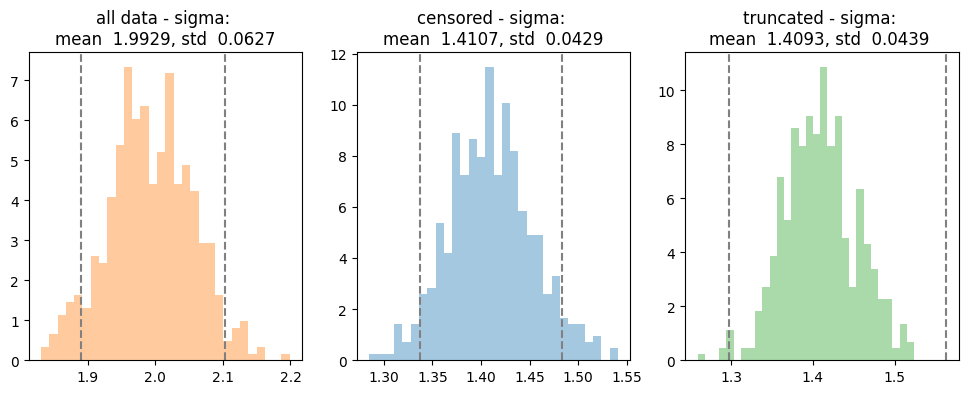

In [487]:
# Visualize uncensored, censored and truncated data
param_ = 'sigma'
_, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].hist(samples_model3[param_].squeeze(), density=True, bins=30, alpha=0.4, color=sns.color_palette()[1], label="all data")
[ax[0].axvline(x=x, c="grey", ls="--") for x in guide3.quantiles([0.05, 0.95])[param_].squeeze()]
_ = ax[0].set(title="all data - {}: \nmean {: .4f}, std {: .4f}".format(param_,
    samples_model3[param_].squeeze().mean(), samples_model3[param_].squeeze().std()))

ax[1].hist(samples_model4[param_].squeeze(), density=True, bins=30, alpha=0.4, color=sns.color_palette()[0],  label="censored")
[ax[1].axvline(x=x, c="grey", ls="--") for x in guide4.quantiles([0.05, 0.95])[param_].squeeze()]
_ = ax[1].set(title="censored - {}: \nmean {: .4f}, std {: .4f}".format(param_,
    samples_model4[param_].squeeze().mean(), samples_model4[param_].squeeze().std()))

ax[2].hist(samples_model5[param_].squeeze(), density=True, bins=30, alpha=0.4, color=sns.color_palette()[2], label="truncated")
[ax[2].axvline(x=x, c="grey", ls="--") for x in guide5.quantiles([0.05, 0.95])[param_].squeeze()]
_ = ax[2].set(title="truncated - {}: \nmean {: .4f}, std {: .4f} ".format(param_,
   samples_model5[param_].squeeze().mean(), samples_model5[param_].squeeze().std()))
